<a href="https://colab.research.google.com/github/Viswesh934/Adobe/blob/main/Curvetopia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
#Plotting a Numpy array
import numpy as np
from scipy.spatial import ConvexHull

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []

        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)

        path_XYs.append(XYs)

    return path_XYs


In [60]:
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.measure import EllipseModel

def plot(paths_XYs, colours):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))

    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]

        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)

    ax.set_aspect('equal')
    plt.show()

def regularize_rounded_rectangle(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    # Approximate radius of rounded corners
    corner_radius = min(width, height) * 0.1

    # Define the corner points
    corners = [
        [min_coords[0] + corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, min_coords[1] + corner_radius],
        [max_coords[0] - corner_radius, max_coords[1] - corner_radius],
        [min_coords[0] + corner_radius, max_coords[1] - corner_radius]
    ]

    # Define the rectangle with rounded corners
    x = [p[0] for p in corners] + [corners[0][0]]
    y = [p[1] for p in corners] + [corners[0][1]]

    return np.column_stack((x, y))

def regularize_polygon(points):
    center = np.mean(points, axis=0)
    radius = np.mean(np.linalg.norm(points - center, axis=1))
    num_sides = len(points)

    angles = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x = center[0] + radius * np.cos(angles)
    y = center[1] + radius * np.sin(angles)

    return np.column_stack((x, y))



In [61]:
def regularize_line(points):
    if len(points) < 2:
        return np.array([])  # Not enough points to form a line

    # Fit a line to the points
    p1, p2 = points[0], points[-1]
    x = np.array([p1[0], p2[0]])
    y = np.array([p1[1], p2[1]])

    return np.column_stack((x, y))


def regularize_ellipse(points):
    if len(points) < 5:
        return np.array([])  # Not enough points to fit an ellipse

    # Fit an ellipse to the points
    ellipse = EllipseModel()
    ellipse.estimate(points)
    xc, yc, a, b, theta = ellipse.params

    num_points = len(points)
    theta_values = np.linspace(0, 2 * np.pi, num_points)
    x = xc + a * np.cos(theta_values) * np.cos(theta) - b * np.sin(theta_values) * np.sin(theta)
    y = yc + a * np.cos(theta_values) * np.sin(theta) + b * np.sin(theta_values) * np.cos(theta)

    return np.column_stack((x, y))




In [82]:
def regularize_circle(points, max_width, max_height, scale_factor=0.9):
    center = np.mean(points, axis=0)
    radius = np.median(np.linalg.norm(points - center, axis=1))

    # Calculate the scale based on the minimum dimension
    min_dimension = min(max_width, max_height)
    scale = (min_dimension * scale_factor) / (2 * radius)

    num_points = len(points)
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = center[0] + radius * scale * np.cos(theta)
    y = center[1] + radius * scale * np.sin(theta)

    return np.column_stack((x, y))



def regularize_rectangle(points, max_width, max_height, scale_factor=0.9):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    width = max_coords[0] - min_coords[0]
    height = max_coords[1] - min_coords[1]

    scale_x = (max_width * scale_factor) / width
    scale_y = (max_height * scale_factor) / height

    # Center of the original rectangle
    center = np.mean(points, axis=0)

    x = [min_coords[0], max_coords[0], max_coords[0], min_coords[0], min_coords[0]]
    y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1], min_coords[1]]

    # Scale and center the rectangle
    x = center[0] + (np.array(x) - center[0]) * scale_x
    y = center[1] + (np.array(y) - center[1]) * scale_y

    return np.column_stack((x, y))


def regularize_star(points):
    center = np.mean(points, axis=0)
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    min_radius = max_radius * 0.4  # Adjusted inner radius for more pronounced star

    num_points = 10  # Number of points in the star (5 outer, 5 inner)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.zeros(num_points)
    radii[::2] = max_radius  # Outer points
    radii[1::2] = min_radius  # Inner points

    x = center[0] + radii * np.cos(angles)
    y = center[1] + radii * np.sin(angles)

    # Ensure the star shape is closed
    x = np.append(x, x[0])
    y = np.append(y, y[0])

    return np.column_stack((x, y))


def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

def identify_shape(points):
    print(len(points))
    if len(points) < 3:
        return 'unknown'  # Not enough points to determine shape

    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull)

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)

    print(f"Compactness: {compactness}, Hull Area: {hull_area}, Hull Perimeter: {hull_perimeter}")

    if compactness > 0.88:
        print("Identified as circle")
        return 'circle'

    # Additional checks for rectangles
    aspect_ratio = calculate_aspect_ratio(points)
    if 0.8 < aspect_ratio < 1.2:
        print("Identified as rectangle")
        return 'rectangle'

    if compactness < 0.7:
        print("Identified as star")
        return 'star'

    return 'unknown'

def calculate_max_extents(points):
    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)

    # Calculate width and height in one step
    extents = max_coords - min_coords

    return extents[0], extents[1]

def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]

    # Calculate distances between vertices
    dists = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(dists)[:2]

    return max(width, height) / min(width, height)


def regularize_shape(points):
    if len(points) == 0:
        return np.array([])  # Return empty array for empty input

    # Determine the maximum extents from the irregular shape
    max_width, max_height = calculate_max_extents(points)

    shape_type = identify_shape(points)

    if shape_type == 'circle':
        return regularize_circle(points, max_width, max_height)
    elif shape_type == 'rectangle':
        return regularize_rectangle(points, max_width, max_height)
    else:
        return regularize_star(points)



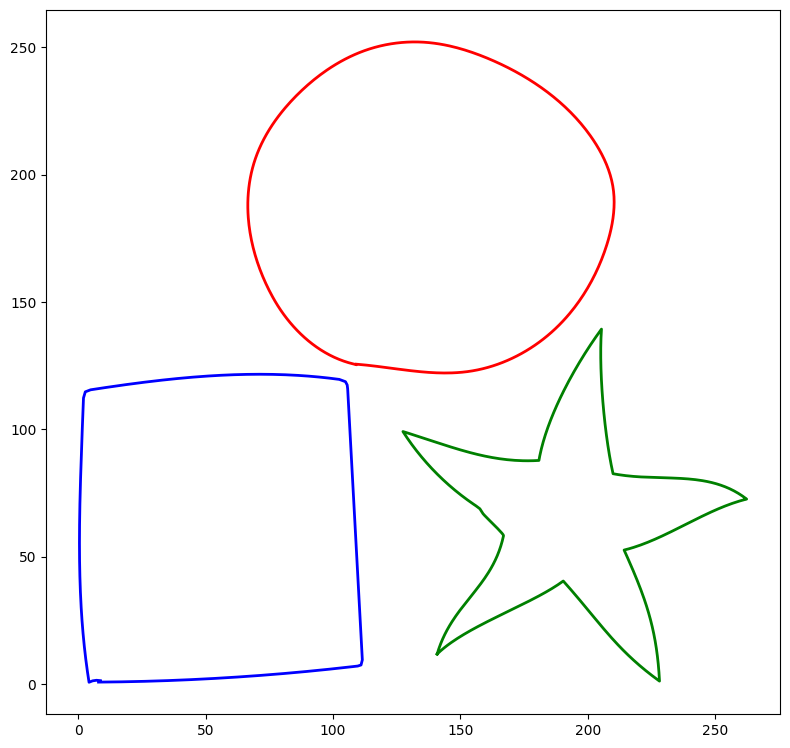

419
Compactness: 0.992289823063742, Hull Area: 14574.535798978466, Hull Perimeter: 429.6185540054191
Identified as circle
550
Compactness: 0.8633480837869744, Hull Area: 12747.868521835717, Hull Perimeter: 430.7554243917191
423
Compactness: 0.8290063799208852, Hull Area: 12521.755472778517, Hull Perimeter: 435.6709521916299
Identified as rectangle


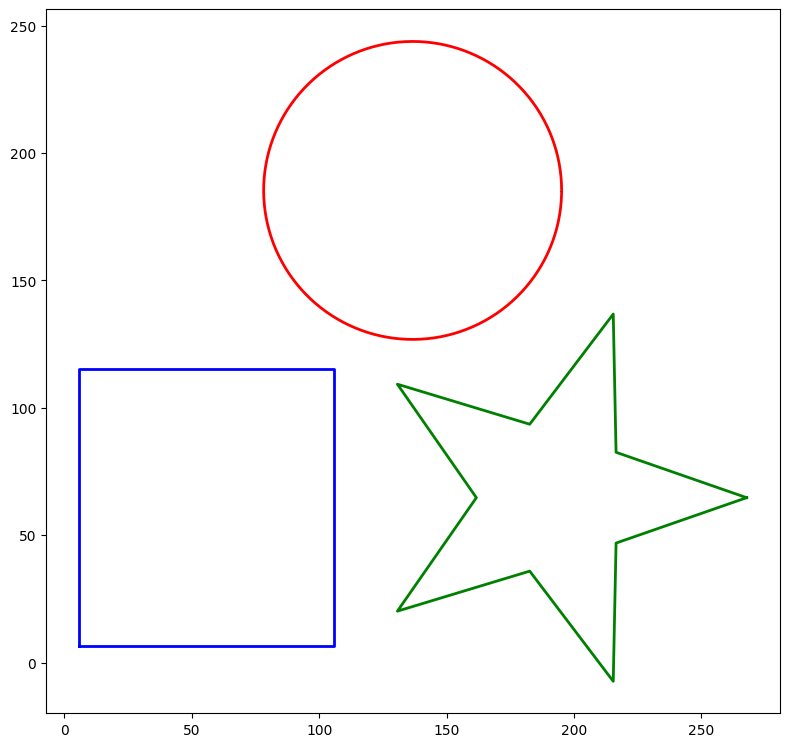

In [83]:
colours = ['r', 'g', 'b', 'y']
pathXY=read_csv('/content/isolated.csv')
regularized_path_XYs = []
plot(pathXY,colours)

for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(shape)
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)
plot(regularized_path_XYs, colours)

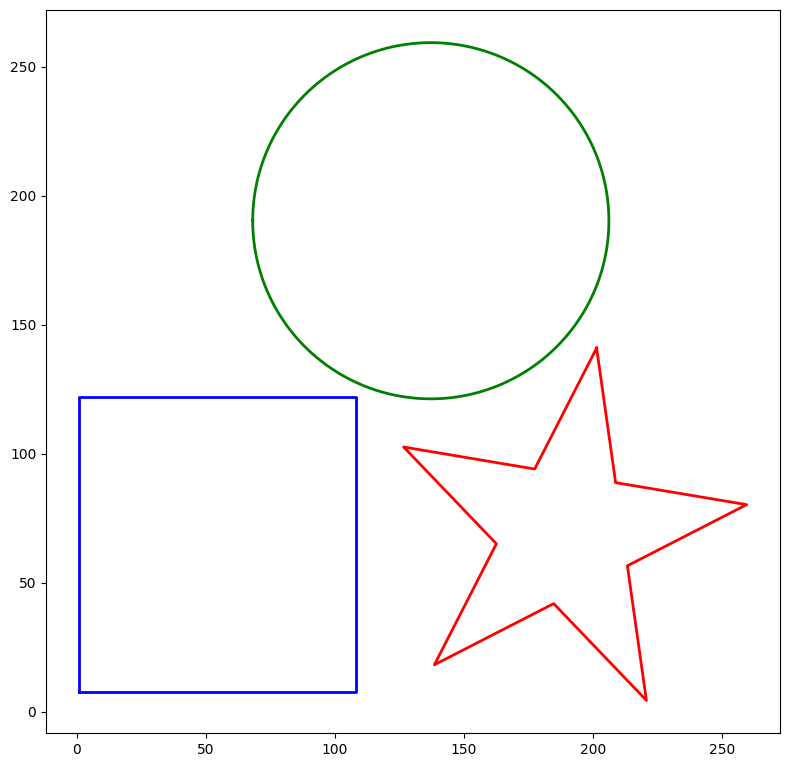

In [37]:
pathXY=read_csv('/content/isolated_sol.csv')
plot(pathXY,colours)